In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("data/cleaned/cleaned_01_Poland_Lithuania_Mixed_final.csv")

In [5]:
df = df.iloc[:, [0,1,2,3,4,6,7,8,5]]

df = df.drop(columns=['Observation id', 'Subs_A', 'Subs_B', 'Early win', 'Comment'])

df = df.rename(columns={"Field_Loc": "Throw_To"})

df = df[~df['Behaviour'].isin(['First half', 'Second half', 'Timeout'])]

df.loc[df['Behaviour'] == 'Score', 'Throw_To'] = 'EZ_Off'

df

,Behaviour,B_Type,Time,Throw_To
1,Time_on_offense_teamA,START,295.667,NaN
2,Pull_pickup,POINT,295.767,Mid_Def
3,Successful_pass,POINT,297.467,Mid_Def
4,Successful_pass,POINT,301.267,Mid_Def
5,Successful_pass,POINT,306.133,Mid_Off
...,...,...,...,...
599,Successful_pass,POINT,6136.733,Mid_Off
600,Successful_pass,POINT,6143.333,RZ_Off
601,Successful_pass,POINT,6148.067,RZ_Off
602,Score,POINT,6153.067,EZ_Off


In [6]:
# df.to_csv("initial_df.csv", index = False)

In [7]:
# Save the rows to hide
hidden_rows = df[df['Behaviour'].isin(['Time_on_offense_teamA', 'Time_on_offense_teamB'])]

# Save their original index so we can restore them later
hidden_rows = hidden_rows.copy()
hidden_rows['original_index'] = hidden_rows.index

# Filter out those rows from the main DataFrame
visible_df = df[~df['Behaviour'].isin(['Time_on_offense_teamA', 'Time_on_offense_teamB'])]

In [8]:
# For example, add a column and fill values
visible_df['Throw_From'] = visible_df['Throw_To'].shift(1)

/var/folders/7n/bd65vv5n0xj0p8tjzcz0k6_80000gn/T/ipykernel_7144/3564026825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visible_df['Throw_From'] = visible_df['Throw_To'].shift(1)


In [9]:
visible_df

,Behaviour,B_Type,Time,Throw_To,Throw_From
2,Pull_pickup,POINT,295.767,Mid_Def,None
3,Successful_pass,POINT,297.467,Mid_Def,Mid_Def
4,Successful_pass,POINT,301.267,Mid_Def,Mid_Def
5,Successful_pass,POINT,306.133,Mid_Off,Mid_Def
6,Successful_pass,POINT,307.467,Mid_Off,Mid_Off
...,...,...,...,...,...
598,Successful_pass,POINT,6133.400,RZ_Off,RZ_Off
599,Successful_pass,POINT,6136.733,Mid_Off,RZ_Off
600,Successful_pass,POINT,6143.333,RZ_Off,Mid_Off
601,Successful_pass,POINT,6148.067,RZ_Off,RZ_Off


In [10]:
# visible_df.to_csv("visible_df.csv", index = False)

In [11]:
# Define the turnover conditions
turnover_mask = visible_df['Behaviour'].isin(['Forced_turnover', 'Unforced_turnover'])

# Shift the turnover mask down by 1 to affect the row after the turnover
rows_to_modify = turnover_mask.shift(fill_value=False)

# Define a function to switch _Off and _Def
def switch_off_def(value):
    if isinstance(value, str):
        if value.endswith('_Off'):
            return value.replace('_Off', '_Def')
        elif value.endswith('_Def'):
            return value.replace('_Def', '_Off')
    return value

# Apply the switch only to rows where the row above was a turnover
visible_df.loc[rows_to_modify, 'Throw_From'] = visible_df.loc[rows_to_modify, 'Throw_From'].apply(switch_off_def)


In [12]:
# visible_df.to_csv("visible_df_2.csv", index = False)

In [13]:
# Add the same column to the hidden rows df
hidden_rows['Throw_From'] = None  # or np.nan, or any placeholder value

In [14]:
# Combine the dataframes
restored_df = pd.concat([visible_df, hidden_rows.drop(columns='original_index')])

# Sort by the original index to restore the original row order
restored_df = restored_df.sort_index()

In [15]:
restored_df.to_csv("restored_df.csv", index = False)

In [16]:
# DIVIDE WINNERS AND LOSERS

# Filter only Time_on_offense_teamA state rows
a_offense_rows = restored_df[restored_df['Behaviour'] == 'Time_on_offense_teamA']

# Get list of start/stop timestamps in order
starts = a_offense_rows[a_offense_rows['B_Type'] == 'START']['Time'].tolist()
stops  = a_offense_rows[a_offense_rows['B_Type'] == 'STOP']['Time'].tolist()

# Zip into intervals
a_intervals = list(zip(starts, stops))

# Filter only Time_on_offense_teamB state rows
b_offense_rows = restored_df[restored_df['Behaviour'] == 'Time_on_offense_teamB']

# Get list of start/stop timestamps in order
starts = b_offense_rows[b_offense_rows['B_Type'] == 'START']['Time'].tolist()
stops  = b_offense_rows[b_offense_rows['B_Type'] == 'STOP']['Time'].tolist()

# Zip into intervals
b_intervals = list(zip(starts, stops))

def rows_in_intervals(df, intervals):
    return df[df['Time'].apply(lambda t: any(start <= t <= end for start, end in intervals))]

df_teamA = rows_in_intervals(restored_df, a_intervals)
df_teamB = rows_in_intervals(restored_df, b_intervals)

In [17]:
print(f'Length team A is {len(df_teamA)} and length team B is {len(df_teamB)}.')

Length team A is 461 and length team B is 248.


In [18]:
# removing the rows that have Behaviour of Time_on_offense_teamA and ..._teamB.

df_teamA = df_teamA[~df_teamA['Behaviour'].isin(['Time_on_offense_teamA', 'Time_on_offense_teamB'])]
df_teamB = df_teamB[~df_teamB['Behaviour'].isin(['Time_on_offense_teamA', 'Time_on_offense_teamB'])]

print(f'After removing the Time_on_offense_*, length team A is {len(df_teamA)} and length team B is {len(df_teamB)}.')

After removing the Time_on_offense_*, length team A is 344 and length team B is 133.


In [19]:
# vraag: moet pull eruit?

In [20]:
df_teamA.to_csv("df_teamA.csv", index = False)

In [21]:
# Filter out rows with missing Throw_From or Throw_To values
# filtered_A = df_teamA.dropna(subset=['Throw_From', 'Throw_To'])
# filtered_B = df_teamB.dropna(subset=['Throw_From', 'Throw_To'])

# print(f'Before filtering, length team A is {len(df_teamA)} and length team B is {len(df_teamB)}.')
# print(f'After filtering, length team A is {len(filtered_A)} and length team B is {len(filtered_B)}.')

In [ ]:
# Now do your count and probability matrix
throw_counts_A = df_teamA.groupby(['Throw_From', 'Throw_To']).size().unstack(fill_value=0)
prob_matrix_A = throw_counts_A.div(throw_counts_A.sum(axis=1), axis=0) # row-normalize

throw_counts_B = df_teamB.groupby(['Throw_From', 'Throw_To']).size().unstack(fill_value=0)
prob_matrix_B = throw_counts_B.div(throw_counts_A.sum(axis=1), axis=0) # row-normalize

In [23]:
throw_counts_A

Throw_To,EZ_Def,EZ_Off,Mid_Def,Mid_Off,RZ_Def,RZ_Off
Throw_From,,,,,,
EZ_Def,8,0,1,0,7,0
EZ_Off,0,0,6,4,5,1
Mid_Def,0,0,53,28,1,1
Mid_Off,0,4,13,81,0,19
RZ_Def,1,1,12,1,32,0
RZ_Off,0,13,0,6,0,45


In [24]:
throw_counts_B

Throw_To,EZ_Off,Mid_Def,Mid_Off,RZ_Def,RZ_Off
Throw_From,,,,,
EZ_Def,1,0,0,0,0
EZ_Off,0,4,5,5,0
Mid_Def,2,11,12,1,1
Mid_Off,9,5,31,0,11
RZ_Def,0,4,3,5,1
RZ_Off,9,0,2,0,11


In [25]:
prob_matrix_A

Throw_To,EZ_Def,EZ_Off,Mid_Def,Mid_Off,RZ_Def,RZ_Off
Throw_From,,,,,,
EZ_Def,0.500000,0.000000,0.062500,0.000000,0.437500,0.000000
EZ_Off,0.000000,0.000000,0.375000,0.250000,0.312500,0.062500
Mid_Def,0.000000,0.000000,0.638554,0.337349,0.012048,0.012048
Mid_Off,0.000000,0.034188,0.111111,0.692308,0.000000,0.162393
RZ_Def,0.021277,0.021277,0.255319,0.021277,0.680851,0.000000
RZ_Off,0.000000,0.203125,0.000000,0.093750,0.000000,0.703125


In [26]:
prob_matrix_B

Throw_To,EZ_Off,Mid_Def,Mid_Off,RZ_Def,RZ_Off
Throw_From,,,,,
EZ_Def,0.062500,0.000000,0.000000,0.000000,0.000000
EZ_Off,0.000000,0.250000,0.312500,0.312500,0.000000
Mid_Def,0.024096,0.132530,0.144578,0.012048,0.012048
Mid_Off,0.076923,0.042735,0.264957,0.000000,0.094017
RZ_Def,0.000000,0.085106,0.063830,0.106383,0.021277
RZ_Off,0.140625,0.000000,0.031250,0.000000,0.171875


In [27]:
combined_A = throw_counts_A.astype(str) + ' (' + (prob_matrix_A * 100).round(1).astype(str) + '%)'
combined_A

Throw_To,EZ_Def,EZ_Off,Mid_Def,Mid_Off,RZ_Def,RZ_Off
Throw_From,,,,,,
EZ_Def,8 (50.0%),0 (0.0%),1 (6.2%),0 (0.0%),7 (43.8%),0 (0.0%)
EZ_Off,0 (0.0%),0 (0.0%),6 (37.5%),4 (25.0%),5 (31.2%),1 (6.2%)
Mid_Def,0 (0.0%),0 (0.0%),53 (63.9%),28 (33.7%),1 (1.2%),1 (1.2%)
Mid_Off,0 (0.0%),4 (3.4%),13 (11.1%),81 (69.2%),0 (0.0%),19 (16.2%)
RZ_Def,1 (2.1%),1 (2.1%),12 (25.5%),1 (2.1%),32 (68.1%),0 (0.0%)
RZ_Off,0 (0.0%),13 (20.3%),0 (0.0%),6 (9.4%),0 (0.0%),45 (70.3%)


In [28]:
combined_B = throw_counts_B.astype(str) + ' (' + (prob_matrix_B * 100).round(1).astype(str) + '%)'
combined_B

Throw_To,EZ_Off,Mid_Def,Mid_Off,RZ_Def,RZ_Off
Throw_From,,,,,
EZ_Def,1 (6.2%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
EZ_Off,0 (0.0%),4 (25.0%),5 (31.2%),5 (31.2%),0 (0.0%)
Mid_Def,2 (2.4%),11 (13.3%),12 (14.5%),1 (1.2%),1 (1.2%)
Mid_Off,9 (7.7%),5 (4.3%),31 (26.5%),0 (0.0%),11 (9.4%)
RZ_Def,0 (0.0%),4 (8.5%),3 (6.4%),5 (10.6%),1 (2.1%)
RZ_Off,9 (14.1%),0 (0.0%),2 (3.1%),0 (0.0%),11 (17.2%)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

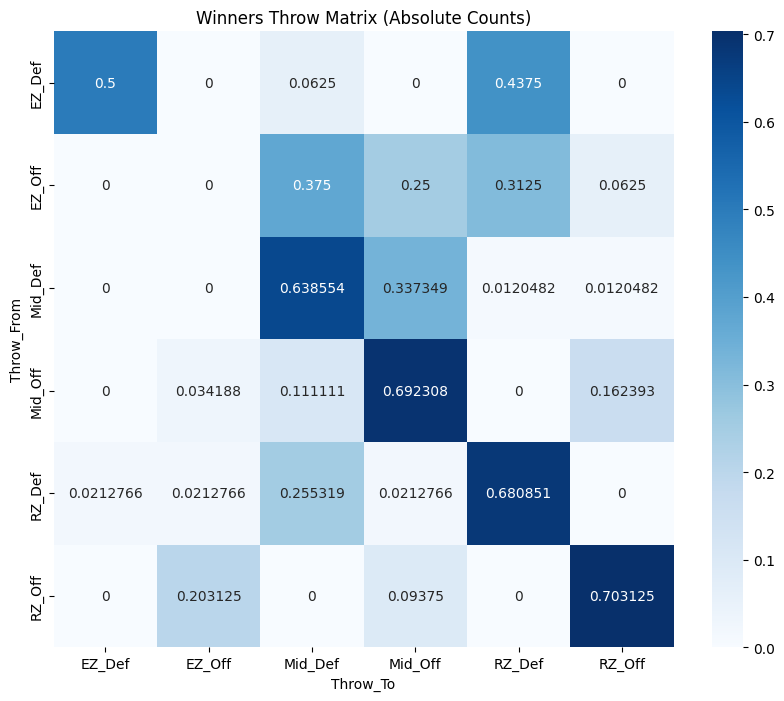

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(prob_matrix_A, cmap='Blues', annot=True, fmt='g')
plt.title("Winners Throw Matrix (Absolute Counts)")
plt.show()

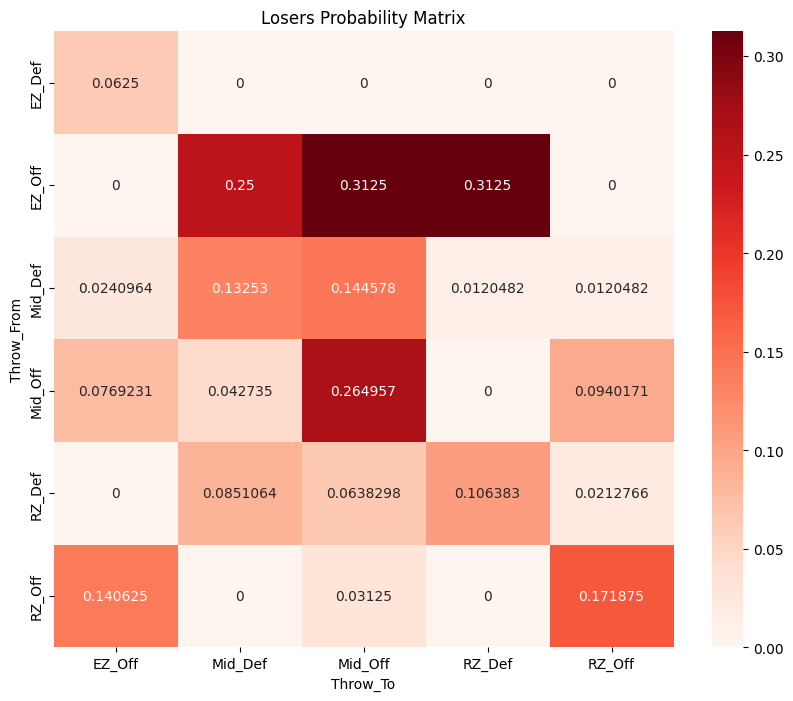

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(prob_matrix_B, cmap='Reds', annot=True, fmt='g')
plt.title("Losers Probability Matrix")
plt.savefig('data/figures/losers_prob_matrix.png')
plt.show()

In [36]:
# Make sure they align
winners_matrix, losers_matrix = prob_matrix_A.align(prob_matrix_B, fill_value=0)

# Subtract
difference_matrix = winners_matrix - losers_matrix

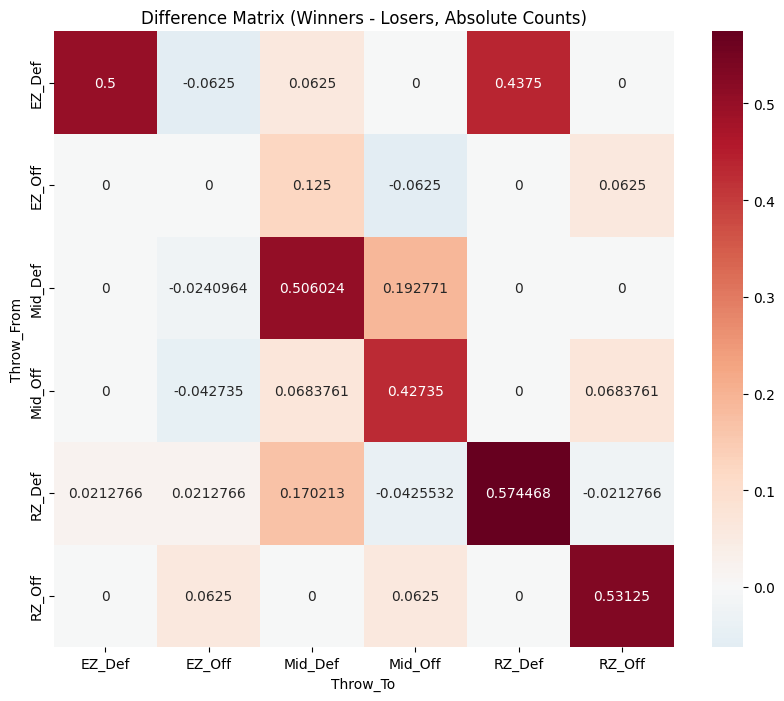

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    difference_matrix,
    cmap='RdBu_r',  # Red for negative, Blue for positive
    center=0,       # 0 = white
    annot=True,
    fmt='g'
)
plt.title("Difference Matrix (Winners - Losers, Absolute Counts)")
plt.show()


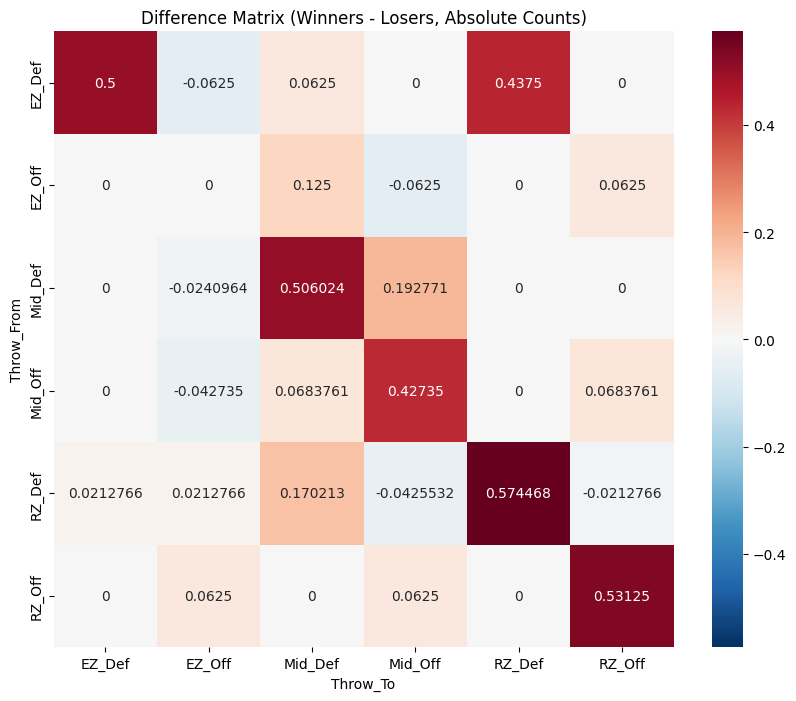

In [38]:
max_val = difference_matrix.abs().max().max()

plt.figure(figsize=(10, 8))
sns.heatmap(
    difference_matrix,
    cmap='RdBu_r',
    center=0,
    vmin=-max_val, vmax=max_val,  # Ensures symmetric color scaling
    annot=True,
    fmt='g'
)
plt.title("Difference Matrix (Winners - Losers, Absolute Counts)")
plt.show()
